## Libraries used
pandas: For data manipulation and analysis.<br>
numpy: For numerical computations.<br>
matplotlib.pyplot: For plotting graphs and visualizations.<br>
keras: For building and training the neural network.<br>
    Sequential: For creating a sequential model.<br>
    Dense: For fully connected (dense) layers.<br>
    Dropout: For dropout layers to prevent overfitting.<br>
    LSTM: For LSTM layers<br>
    Bidirectional: For bidirectional LSTM layers.<br>
    BatchNormalization: For batch normalization layers to stabilize and accelerate training.<br>
    Input: For specifying the input shape.<br>
    Adam: For the Adam optimizer.<br>
    EarlyStopping: For stopping training early if the model stops improving.<br>
sklearn.preprocessing: For feature scaling.<br>
RobustScaler: For scaling features to make the model more robust to outliers.<br>


## Model Architecture
The model is a sequential neural network with the following layers:<br>
<br>
Input Layer:<br>
<br>
Shape: (time_step, number_of_features) which is (10, 4) in this case.<br>
First Bidirectional LSTM Layer:<br>
<br>
Units: 50<br>
return_sequences=True: This layer returns the full sequence.<br>
Batch Normalization Layer:<br>
<br>
Normalizes the activations of the previous layer.<br>
Dropout Layer:<br>
<br>
Dropout rate: 0.2 (20% of the units are dropped during training).<br>
Second Bidirectional LSTM Layer:<br>
<br>
Units: 50<br>
return_sequences=True: This layer returns the full sequence.<br>
Batch Normalization Layer:<br>
<br>
Normalizes the activations of the previous layer.<br>
Dropout Layer:<br>
<br>
Dropout rate: 0.2 (20% of the units are dropped during training).<br>
Third Bidirectional LSTM Layer:<br>
<br>
Units: 50<br>
Dense Layer:<br>
<br>
Units: 4 (Corresponding to the 4 features being predicted: Open, Close, % Momentum).<br>

## Process of Loading the Data.<br><br>
Load dataset: The dataset is read from a CSV file using pandas.<br><br>
Remove NaN values: Rows with NaN values in the 'Open' or 'Close' columns are removed.<br><br>
Calculate % Momentum: A new feature, % Momentum, is calculated based on the 'Close' prices over a 7-day period.<br><br>
Calculate Daily Returns: Daily returns are calculated.<br><br>
Calculate Volatility: Volatility is calculated as the rolling standard deviation of returns over a 10-day window.<br><br>
Prepare data: The relevant columns ('Open', 'Close', '% Momentum', 'Volatility') are selected, and the 'Date' column is converted to datetime format and set as the index.<br><br>
Feature Scaling: The data is scaled using RobustScaler.<br><br>
Split data into training and test sets: The data is split into training and test sets.<br><br>
Create sequences: Sequences and labels are created using a time step of 10.<br><br>


## Training Parameters<br><br>
Number of Epochs: 500 (but training can stop early if the model stops improving due to early stopping).<br><br>
Batch Size: 64<br><br>
Early Stopping: The training will stop early if the loss does not improve for 10 consecutive epochs, and the best weights will be restored.

# Final_model

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Input
from keras.optimizers import Adam
from sklearn.preprocessing import RobustScaler
from keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv("TATAMOTORS.NS2.csv")

# Remove rows with NaN values in 'Open' or 'Close' columns
df = df.dropna(subset=['Open', 'Close'])

# Calculate % Momentum feature
n = 7  # Number of days for momentum calculation
df['% Momentum'] = (df['Close'].diff(n) / df['Close'].shift(n)) * 100  # % Momentum

# Handle NaN values in % Momentum
df['% Momentum'].fillna(0, inplace=True)

# Calculate daily returns
df['Returns'] = df['Close'].pct_change()

# Calculate rolling standard deviation of returns as volatility
volatility_window = 10  # Adjust the window size as needed
df['Volatility'] = df['Returns'].rolling(window=volatility_window).std()

# Handle NaN values in Volatility
df['Volatility'].fillna(df['Volatility'].mean(), inplace=True)

# Prepare data including % Momentum and Volatility features
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Open', 'Close', '% Momentum', 'Volatility']]

# Feature Scaling with adjusted range for RobustScaler
sc = RobustScaler()
data_scaled = sc.fit_transform(data)

# Define a smaller time_step
time_step = 10

# Split the data into training and test sets
train_data = data_scaled[:8426]
test_data = data_scaled[8426:]

# Function to create sequences
def create_sequence(dataset, time_step):
    sequences = []
    labels = []
    for start_idx in range(len(dataset) - time_step):
        end_idx = start_idx + time_step
        sequences.append(dataset[start_idx:end_idx])
        labels.append(dataset[end_idx])
    return np.array(sequences), np.array(labels)

# Create sequences with time step
train_seq, train_label = create_sequence(train_data, time_step)

# Check shapes of the sequences and labels
print(f"Train sequences shape: {train_seq.shape}")
print(f"Train labels shape: {train_label.shape}")

# Build the LSTM model with input layer
model = Sequential()
model.add(Input(shape=(time_step, train_seq.shape[2])))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='relu')))  # Reduced units with ReLU
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Reduced dropout
model.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='relu')))  # Reduced units with ReLU
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Reduced dropout
model.add(Bidirectional(LSTM(units=50, activation='relu')))  # Reduced units with ReLU
model.add(Dense(4))  # Last dense layer with 4 units

# Compile the model with adjusted learning rate
optimizer = Adam(learning_rate=1e-4, clipvalue=0.5)  # Adjusted learning rate and gradient clipping
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(train_seq, train_label, epochs=500, batch_size=64, verbose=1, callbacks=[early_stopping])

# Make predictions for the next 30 days
predictions = []
input_seq = train_data[-time_step:].reshape(1, time_step, train_seq.shape[2])

for _ in range(30):
    predicted = model.predict(input_seq)
    predictions.append(predicted[0])
    input_seq = np.append(input_seq[:, 1:, :], predicted.reshape(1, 1, train_seq.shape[2]), axis=1)

# Inverse transform the predictions
predictions = np.array(predictions)
predictions_inverse = sc.inverse_transform(predictions)

# Create dates for the predicted data
predicted_dates = pd.date_range(start=df.index[-1], periods=30)

# Create a DataFrame for visualization
predicted_df = pd.DataFrame(predictions_inverse, index=predicted_dates, columns=['Predicted_Open', 'Predicted_Close', 'Predicted_%_Momentum', 'Predicted_Volatility'])


C:\Users\iamha\AppData\Local\Temp\ipykernel_2864\1500726266.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['% Momentum'].fillna(0, inplace=True)
C:\Users\iamha\AppData\Local\Temp\ipykernel_2864\1500726266.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

Train sequences shape: (8416, 10, 4)
Train labels shape: (8416, 4)
Epoch 1/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.7501 - mean_absolute_error: 0.5802
Epoch 2/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.3786 - mean_absolute_error: 0.3945
Epoch 3/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.3029 - mean_absolute_error: 0.3486
Epoch 4/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.2485 - mean_absolute_error: 0.3271
Epoch 5/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2366 - mean_absolute_error: 0.3110
Epoch 6/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.2053 - mean_absolute_error: 0.2981
Epoch 7/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1969 - mean_absolute_error: 0.2893
Epoch 8/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1923 - mean_absolute_error: 0.2798
Epoch 9/500
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1671 - mean_absolute_error: 0.2734
Epoch 10/500
132/132 ━━━━━━━━━━━━━━━━━━━━

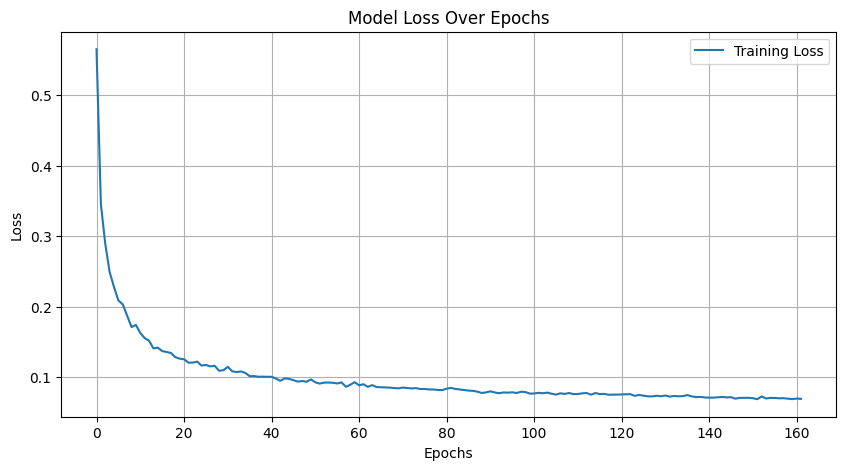

In [9]:
# Plot the loss function against epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error  # Import mean_absolute_error
# Assuming `predicted_df` is a DataFrame with 'Predicted_Open' column
predicted_open_values = predicted_df['Predicted_Open'].values
actual_open=data['Open'][-30:].values
# Ensure both arrays have the same number of elements
print(len(actual_open), len(predicted_open_values))

# Check the first few elements to see where the discrepancy might be
print('Actual Open:', actual_open)
print('Predicted Open:', predicted_open_values)

# Calculate MAE
mae_open = mean_absolute_error(actual_open, predicted_open_values)
print('Mean Absolute Error for Open Prices:', mae_open)

30 30
Actual Open: [1011.       1037.       1005.        965.099976  970.950012  953.200012
  944.        954.        952.        950.        962.5       964.900024
  959.        946.950012  943.5       931.650024  963.        948.
  924.950012  940.        940.        977.        973.799988  994.5
 1002.        990.       1000.        990.        980.        979.      ]
Predicted Open: [986.8183  988.2804  988.9387  990.5092  991.03796 989.9008  984.4851
 978.2872  973.12054 973.6685  974.9953  975.55707 975.806   975.87854
 975.78375 975.56055 975.0056  974.47174 974.08777 973.7103  973.1138
 972.3547  971.46185 970.4758  969.47925 968.5326  967.68677 966.9634
 966.3502  965.8281 ]
Mean Absolute Error for Open Prices: 24.913653612760413


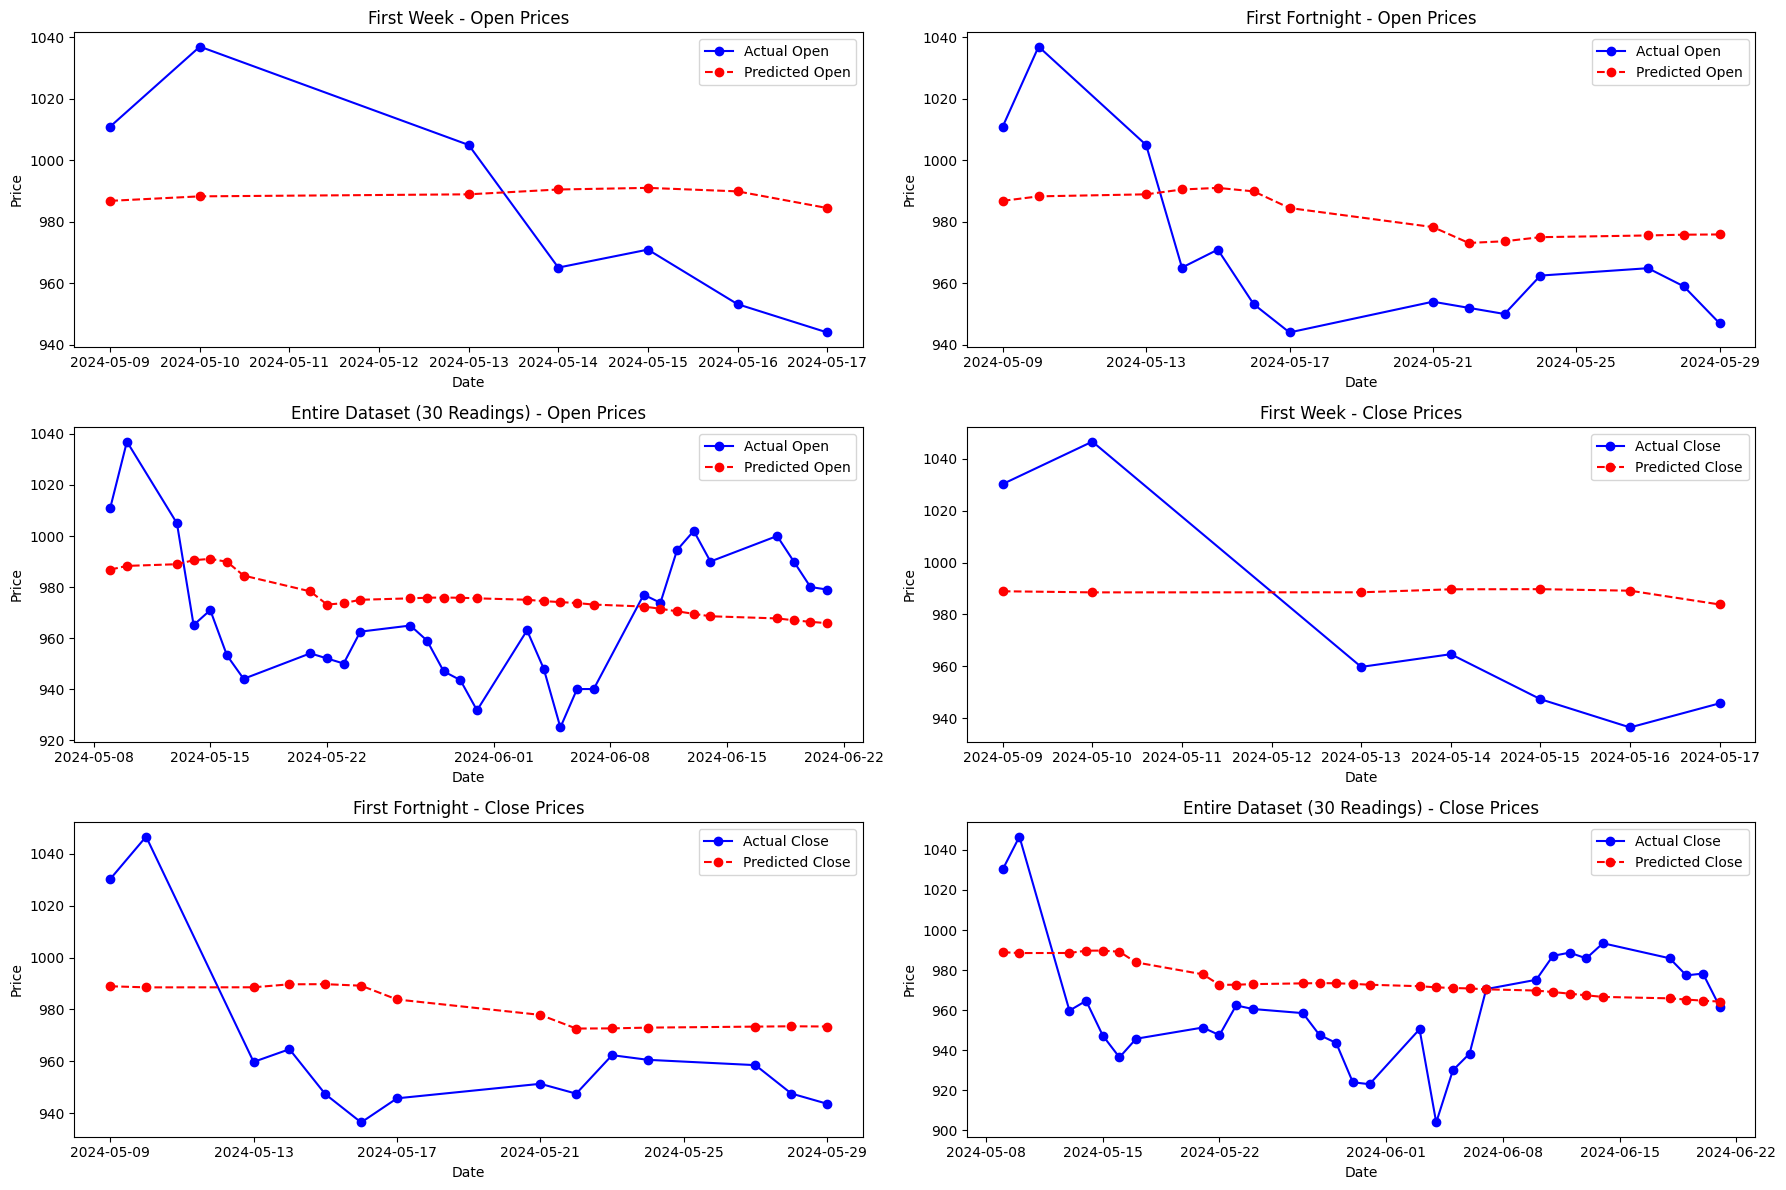

In [12]:
# Extract the actual last 30 days data
actual_last_30_days = data[-30:]

# Create a DataFrame for the predicted data
predicted_dates = actual_last_30_days.index  # Use the same dates as the actual data
predicted_df = pd.DataFrame(predictions_inverse, index=predicted_dates, columns=['Predicted_Open', 'Predicted_Close', 'Predicted_%_Momentum', 'Predicted_Volatility'])

last_30_open = data['Open'][-30:]
last_30_close = data['Close'][-30:]
last_30_momentum = data['% Momentum'][-30:]
last_30_volatility = data['Volatility'][-30:]

# Step 2: Ensure predicted_df['Predicted_Open'] is also a Series with the same index
predicted_open = predicted_df['Predicted_Open']
predicted_close = predicted_df['Predicted_Close']
predicted_momentum = predicted_df['Predicted_%_Momentum']
predicted_volatility = predicted_df['Predicted_Volatility']
# Step 3: Combine these into a single DataFrame
combined_df_open = pd.DataFrame({
    'Open': last_30_open,
    'Predicted_Open': predicted_open
})
combined_df_close = pd.DataFrame({
    'Open': last_30_close,
    'Predicted_Open': predicted_close
})
combined_df_momentum = pd.DataFrame({
    'Open': last_30_momentum,
    'Predicted_Open': predicted_momentum
})
combined_df_volatility = pd.DataFrame({
    'Open': last_30_volatility,
    'Predicted_Open': predicted_volatility
})
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already created the combined DataFrames as per your previous code

# Plotting the data
plt.figure(figsize=(18, 12))  # Adjust figure size as needed

# Plot for Open prices
plt.subplot(3, 2, 1)
plt.plot(combined_df_open.index[:7], combined_df_open['Open'][:7], marker='o', linestyle='-', color='b', label='Actual Open')
plt.plot(combined_df_open.index[:7], combined_df_open['Predicted_Open'][:7], marker='o', linestyle='--', color='r', label='Predicted Open')
plt.title('First Week - Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(combined_df_open.index[:14], combined_df_open['Open'][:14], marker='o', linestyle='-', color='b', label='Actual Open')
plt.plot(combined_df_open.index[:14], combined_df_open['Predicted_Open'][:14], marker='o', linestyle='--', color='r', label='Predicted Open')
plt.title('First Fortnight - Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(combined_df_open.index, combined_df_open['Open'], marker='o', linestyle='-', color='b', label='Actual Open')
plt.plot(combined_df_open.index, combined_df_open['Predicted_Open'], marker='o', linestyle='--', color='r', label='Predicted Open')
plt.title('Entire Dataset (30 Readings) - Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot for Close prices
plt.subplot(3, 2, 4)
plt.plot(combined_df_close.index[:7], combined_df_close['Open'][:7], marker='o', linestyle='-', color='b', label='Actual Close')
plt.plot(combined_df_close.index[:7], combined_df_close['Predicted_Open'][:7], marker='o', linestyle='--', color='r', label='Predicted Close')
plt.title('First Week - Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(combined_df_close.index[:14], combined_df_close['Open'][:14], marker='o', linestyle='-', color='b', label='Actual Close')
plt.plot(combined_df_close.index[:14], combined_df_close['Predicted_Open'][:14], marker='o', linestyle='--', color='r', label='Predicted Close')
plt.title('First Fortnight - Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(combined_df_close.index, combined_df_close['Open'], marker='o', linestyle='-', color='b', label='Actual Close')
plt.plot(combined_df_close.index, combined_df_close['Predicted_Open'], marker='o', linestyle='--', color='r', label='Predicted Close')
plt.title('Entire Dataset (30 Readings) - Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
